In [1]:
import sys
import os
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from dotenv import load_dotenv
import google.generativeai as genai

if str(Path().resolve().parent) not in sys.path:
    sys.path.append(str(Path().resolve().parent))

load_dotenv()
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

warnings.filterwarnings("ignore", category=FutureWarning)

from src.config import (random_seed, PREPROCESSED_BLOG_DATASET_PATH, CLASSIFICATION_MAP, NUMERIC_RESULTS_PATH,
                        NORMALIZED_NUMERIC_RESULTS_PATH, CLASSIFICATION_ACC_RESULTS_PATH, CLASSIFICATION_MAE_RESULTS_PATH,
                        CLASSIFICATION_RMSE_RESULTS_PATH, PREPROCESSED_DEEPMIND_BLOG_DATASET_PATH, DEEPMIND_BLOG_EVALUATION_RESULTS_PATH)
from src.models_setup import gemini_2_flash, gemini_2_flash_lite, gemini_1_5_flash
from src.prompts import *
from src.output_formats import *
from src.helpers import extract_llm_assessment

# Data Processing

In [4]:
# Import data
blogs = pd.read_csv(PREPROCESSED_BLOG_DATASET_PATH)
google_blogs = pd.read_csv(PREPROCESSED_DEEPMIND_BLOG_DATASET_PATH)

# Split dataset into validation and test set
Xval, Xtest, yval_score, ytest_score = train_test_split(
    blogs.drop(columns=['normalized_engagement_score']), blogs["normalized_engagement_score"],
    test_size=0.4, random_state=random_seed)

# Same Xval, Xtest; new explained variable "engagement_level"
Xval, Xtest, yval_level, ytest_level = train_test_split(
    blogs.drop(columns=['engagement_level', 'normalized_engagement_score']), blogs["engagement_level"],
    test_size=0.4, random_state=random_seed)

print(f"Size of validation set, X: {Xval.shape}, y: {yval_score.shape}")
print(f"Size of test set, X: {Xtest.shape}, y: {ytest_score.shape}")

Size of validation set, X: (30, 13), y: (30,)
Size of test set, X: (20, 13), y: (20,)


In [5]:
# The best blog in dataset
best_blog_info = Xval.sort_values(["engagement_score"], ascending=False).head(1)
best_blog_index = best_blog_info.index[0]
best_blog_info = best_blog_info.reset_index(drop=True)
best_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,publisher_followers,title_paper,url_paper,publisher_blog,blog_full_text,engagement_score
0,47,Towards Reinforcement Learning Inspired By Hum...,https://medium.com/stanford-aiforhi/towards-re...,Ramtin Keramati,42,227,2,111.0,Fast Exploration with Simplified Models and Ap...,https://arxiv.org/pdf/1806.00175,Stanford AI for Human Impact,# Towards Reinforcement Learning Inspired By H...,4.14218


In [6]:
# The worst blog in dataset
worst_blog_info = Xval.sort_values(["engagement_score"], ascending=False).tail(1)
worst_blog_index = worst_blog_info.index[0]
worst_blog_info = worst_blog_info.reset_index(drop=True)
worst_blog_info

,id,title_blog,url_blog,author_blog,author_followers,claps,comments,publisher_followers,title_paper,url_paper,publisher_blog,blog_full_text,engagement_score
0,2,Recurrent drafter for fast speculative decodin...,https://medium.com/@sulbha.jindal/recurrent-dr...,Sulbha Jain,41,1,0,0.0,Recurrent drafter for fast speculative decodin...,https://arxiv.org/pdf/2403.09919,Sulbha Jain,# Recurrent drafter for fast speculative decod...,0.237083


In [7]:
blog_text = blogs.loc[0, "blog_full_text"]
print(blog_text)

# Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review

Paper — https://arxiv.org/pdf/2411.16646

Reinforcement Learning from Human Feedback (RLHF) has become a critical methodology for aligning large language models (LLMs) with human preferences. At the core of RLHF lies the reward model (RM), which is designed to evaluate model outputs by assigning scores that reflect their alignment with human judgments. These scores guide the optimization process during training, such as providing reward signals in Proximal Policy Optimization (PPO), thereby encouraging LLMs to generate responses that are more helpful, honest, and harmless. This iterative process enhances the practical quality of LLM outputs in real-world applications.

## Current challenge

Typically, reward models are trained using preference pairs and optimized through pairwise logistic loss to produce a scalar score for each response. However, this scalar output is often hard to interpret and underut

In [8]:
best_blog = {
    "blog": best_blog_info.loc[0, "blog_full_text"],
    "score" : yval_score.loc[best_blog_index]
}
worst_blog = {
    "blog" : worst_blog_info.loc[0, "blog_full_text"],
    "score" : yval_score.loc[worst_blog_index]
}

In [9]:
excellent_blog_index = yval_level[yval_level == "Excellent"].index.min()
excellent_blog = blogs.loc[excellent_blog_index, "blog_full_text"]
with open("../data/examples/excellent_blog", "w", encoding="utf-8") as file:
    file.write(excellent_blog)

very_good_blog_index = yval_level[yval_level == "Very Good"].index.min()
very_good_blog = blogs.loc[very_good_blog_index, "blog_full_text"]
with open("../data/examples/very_good_blog", "w", encoding="utf-8") as file:
    file.write(very_good_blog)

good_blog_index = yval_level[yval_level == "Good"].index.min()
good_blog = blogs.loc[good_blog_index, "blog_full_text"]
with open("../data/examples/good_blog", "w", encoding="utf-8") as file:
    file.write(good_blog)

average_blog_index = yval_level[yval_level == "Average"].index.min()
average_blog = blogs.loc[average_blog_index, "blog_full_text"]
with open("../data/examples/average_blog", "w", encoding="utf-8") as file:
    file.write(average_blog)

bad_blog_index = yval_level[yval_level == "Bad"].index.min()
bad_blog = blogs.loc[bad_blog_index, "blog_full_text"]
with open("../data/examples/bad_blog", "w", encoding="utf-8") as file:
    file.write(bad_blog)

# Prompt Engineering

In [8]:
def test_prompt(prompt_template, model, input_variables):
    """Testing the operation of LLM with a given prompt template."""
    test_chain = prompt_template | model
    test_response = test_chain.invoke(input_variables)
    print(f"Usage metadata:\n{test_response.usage_metadata}")
    print(f"\nContent:\n{test_response.content}")

In [9]:
# One word answer
test_prompt(prompt_simple_answer, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1138, 'output_tokens': 3, 'total_tokens': 1141, 'input_token_details': {'cache_read': 0}}

Content:
Informative


In [10]:
# Adding numerical assessment
test_prompt(prompt_numeric_rating, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1143, 'output_tokens': 8, 'total_tokens': 1151, 'input_token_details': {'cache_read': 0}}

Content:
Informative 8/10


In [11]:
# Scale from 1 to 100 + short comment
test_prompt(prompt_short_comment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1154, 'output_tokens': 112, 'total_tokens': 1266, 'input_token_details': {'cache_read': 0}}

Content:
**Score: 85/100**

**Comment:** This is a well-written and concise summary of the Critic-RM paper. It clearly explains the problem, methodology, results, and implications of the research. The use of bolding and headings makes it easy to read and understand. The explanations are concise, making the material digestible for a wider audience.

However, it could benefit from a bit more critical analysis (not just a summary). For example, mentioning potential limitations of the approach or open questions raised by the research.


In [12]:
# Emphasizing the importance of engagement
test_prompt(prompt_engagement_score, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1160, 'output_tokens': 101, 'total_tokens': 1261, 'input_token_details': {'cache_read': 0}}

Content:
**Engagement Level: 55/100**

**Comment:** The blog post provides a clear and concise summary of a research paper. It breaks down complex concepts into understandable terms, which is good for accessibility. However, it lacks interactive elements (like questions for the reader, polls, or a comment section). Also, it is a very niche topic so that it won't be of interest to many readers. Adding those elements, and posting to niche communities would likely boost engagement.


In [13]:
# Assessment based on several criteria
test_prompt(prompt_criteria, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1184, 'output_tokens': 431, 'total_tokens': 1615, 'input_token_details': {'cache_read': 0}}

Content:
**Assessment:**

*   **Readability:** The writing style is generally clear and concise, suitable for an audience familiar with machine learning and NLP concepts. However, some sections could benefit from further simplification to improve accessibility for a broader audience. The use of technical terms like "Proximal Policy Optimization (PPO)" and "$$r = r_\psi(x, [y, z])$$" might be intimidating for some readers.
*   **Structure:** The blog post follows a logical structure, starting with an introduction to the problem, discussing the proposed methodology, presenting results, and concluding with a summary. The use of headings and subheadings makes it easy to navigate.
*   **Attractiveness of the Blog Title:** The title is descriptive and accurately reflects the content of the blog post. It's likely to attract readers interested in reward modeling and lan

In [14]:
# Separate assessment
test_prompt(prompt_separate_assessment, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1211, 'output_tokens': 586, 'total_tokens': 1797, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's an analysis of the blog post based on the given criteria, with scores out of 100:

**Criterion Breakdown:**

*   **Readability (75/100):** The writing style is generally clear and uses technical terms appropriately for the intended audience (those familiar with LLMs and RLHF). However, some sentences are dense and could be broken down for easier digestion. Use of mathematical notation is appropriate.
*   **Structure (85/100):** The blog post follows a logical structure: introduction, problem statement, proposed solution (Critic-RM), methodology, results, and summary. The use of headings and subheadings makes it easy to navigate. Could benefit from slightly more visual separation (e.g., bullet points for listing advantages or disadvantages in the discussion).
*   **Informativeness (90/100):** The blog post provides a good overview of the pap

In [15]:
# Add information about profile of the model
test_prompt(prompt_with_profile, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1239, 'output_tokens': 733, 'total_tokens': 1972, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's my analysis of the blog post, broken down by the requested criteria and culminating in an overall assessment. I will be strict and precise in my evaluation.

**Individual Criterion Scores:**

*   **Readability (75/100):** The blog post uses relatively clear language, but it still contains jargon that may not be accessible to a completely general audience (e.g., "Proximal Policy Optimization (PPO)", "pairwise logistic loss"). The use of headings and subheadings helps to break up the text and improve readability. Sentences are generally of a reasonable length, but could be shorter for better clarity.
*   **Structure (85/100):** The blog follows a logical structure: introduction, problem statement, proposed solution (methodology), results, and conclusion. The use of headings is good. The inclusion of a link to the original paper is appreciated

In [16]:
# Well-structured sections of the prompt
test_prompt(prompt_structured_sections, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1342, 'output_tokens': 838, 'total_tokens': 2180, 'input_token_details': {'cache_read': 0}}

Content:
Okay, here's my evaluation of the provided blog post, broken down by the specified criteria, followed by an overall score and suggestions for improvement.

**Criterion Breakdown:**

*   **Readability (70/100):** The language is generally clear, but there are instances of jargon (e.g., "pairwise logistic loss," "Proximal Policy Optimization (PPO)") without sufficient explanation for a broader audience. Sentence length is reasonable, but some sentences are dense.
*   **Structure (85/100):** The blog post follows a logical structure: introduction, problem statement, proposed solution (Critic-RM), methodology, results, and summary. The use of headings and subheadings helps to organize the content.
*   **Informativeness (80/100):** The blog post provides a good overview of the Critic-RM framework and its benefits. It accurately summarizes the key aspects of 

In [17]:
# 2-shot prompt
test_prompt(prompt_two_shots, gemini_2_flash, {
    "blog_text" : blog_text,
    "blog_ex1" : best_blog["blog"],
    "score_ex1" : best_blog["score"],
    "blog_ex2" : worst_blog["blog"],
    "score_ex2" : worst_blog["score"]
})

Usage metadata:
{'input_tokens': 3674, 'output_tokens': 306, 'total_tokens': 3980, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "overall_assessment": 60.0,
  "explanation": "The blog post provides a decent overview of the research paper. However, it struggles in several areas that impact its overall engagement level. While the blog introduces the problem and the proposed solution (Critic-RM) adequately, it doesn't explain the methodology and the results clearly enough for a broad audience. The structure is reasonable, following a standard format (Introduction, Challenges, Methodology, Results, Summary), but the writing style could be more accessible. The title is functional but not particularly eye-catching. The potential for discussion is moderate; while the topic is relevant, the current presentation might not spark widespread interest due to its technical nature and lack of engaging narrative.",
  "possible_improvements": [
    "Simplify the explanation of the met

In [18]:
# 5-shot prompt with verbal classification
test_prompt(prompt_five_shots, gemini_2_flash, {
    "blog_text": blog_text,
    "excellent_blog": excellent_blog,
    "very_good_blog": very_good_blog,
    "good_blog": good_blog,
    "average_blog": average_blog,
    "bad_blog": bad_blog
})

Usage metadata:
{'input_tokens': 10131, 'output_tokens': 278, 'total_tokens': 10409, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "overall_engagement_level": "Good",
  "assessment_explanation": "The blog post provides a reasonably clear overview of the research paper. The structure, with sections like \"Current challenge\", \"Methodology\", \"Results\", and \"Summary\", aids understanding. However, the content assumes some familiarity with the field of Reinforcement Learning and Large Language Models, which may limit its appeal to a broader audience. Additionally, while the title is descriptive, it could be more attention-grabbing. The clarity is generally good, but some parts are dense and could benefit from further simplification. The potential for discussion is moderate; while the topic is relevant, the presentation is more descriptive than analytical or critical.",
  "possible_improvements": [
    "Include a brief introductory section explaining the basics of Rei

In [19]:
# Zero-shot Chain-of-Thoughts
test_prompt(prompt_zero_cot, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1426, 'output_tokens': 540, 'total_tokens': 1966, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "readability": "Good. The blog uses technical terms specific to the field, which might be challenging for readers unfamiliar with LLMs and reinforcement learning. However, the explanations are generally clear and concise, and the sentence structure is not overly complex.",
  "structure": "Very Good. The blog follows a logical structure, starting with an introduction to the problem, followed by the proposed solution (Critic-RM), the methodology, results, and a summary. The use of headings and subheadings makes it easy to navigate and understand the content.",
  "informativeness": "Good. The blog provides a good overview of the research paper, explaining the core concepts, methodology, and results. However, it could benefit from more in-depth explanations of certain aspects, such as the specific techniques used for consistency-guided filtering

In [20]:
# Generated knowledge
test_prompt(prompt_generated_knowledge, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1409, 'output_tokens': 791, 'total_tokens': 2200, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
  "key_analysis": {
    "readability": "Evaluated based on sentence structure, vocabulary, and the use of jargon. Shorter sentences and simpler vocabulary lead to higher scores. Excessive jargon without explanation lowers the score.",
    "structure": "Assessed by the logical flow of information, the use of headings and subheadings, and the presence of a clear introduction and conclusion. Well-organized content receives a higher score.",
    "informativeness": "Determined by the depth and breadth of the information provided, the inclusion of relevant details, and the overall educational value of the blog post. Comprehensive and insightful content scores higher.",
    "attractiveness_of_blog_title": "Evaluated on how well the title captures attention, indicates the blog's content, and entices readers to click. Clear, concise, and intriguing tit

In [21]:
# Meta prompt
test_prompt(prompt_meta, gemini_2_flash, {"blog_text": blog_text})

Usage metadata:
{'input_tokens': 1610, 'output_tokens': 848, 'total_tokens': 2458, 'input_token_details': {'cache_read': 0}}

Content:
```json
{
    "Referenced blog to evaluate": "Self-Generated Critiques Boost Reward Modeling for LanguageModels — Paper Review",
    "Step 1": "Analyze the readability of the blog. Is the text easy to understand? Are the sentences clear and well-structured? The readability is moderate. While the sentences are generally well-structured, the technical jargon and specific terminology related to LLMs and reinforcement learning might be challenging for readers without a background in the field. The use of acronyms like RLHF and LLM without consistent initial explanation could also hinder understanding.",
    "Step 2": "Evaluate the structure of the blog. Does it follow a logical flow? Are the sections well-organized? The structure is generally logical, with clear sections like 'Current Challenge,' 'Methodology,' 'Results,' and 'Summary.' However, a more expl

# Performance testing on a validation set

In [12]:
# Models
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogEvaluation, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogEvaluation, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogEvaluation, include_raw=True)

# Number of experiment repetitions
REPETITION = 5

ERROR_VALUE = -1

In [13]:
def show_scatter_plot(real_values, predicted_values):
    plt.scatter(real_values, predicted_values, color='blue')
    plt.plot([min(real_values), max(real_values)], [min(real_values), max(real_values)], color='red', linestyle='--')
    plt.xlabel('Real values')
    plt.ylabel('Predicted values')
    plt.title('Real vs Predicted values')
    plt.show()

def print_and_save_numeric_results(result_path, yval, assessments, model, loc_start):
    RMSE_list = [round(metrics.root_mean_squared_error(yval, assessment), 1) for assessment in assessments]
    print(f"Root Mean Square Error on validation set after {REPETITION} same experiments: {RMSE_list}")

    MAE_list = [round(metrics.mean_absolute_error(yval, assessment), 1) for assessment in assessments]
    print(f"Mean Absolute Error on validation set after {REPETITION} same experiments: {MAE_list}")

    try:
        results = pd.read_csv(result_path)
    except Exception as e:
        print(f"{e}\n"
              f"Creating new .csv file...")
        col = ["Model", "Experiment_ID", "RMSE", "MAE"]
        results = pd.DataFrame(columns=col)

    for index in range(REPETITION):
        results.loc[loc_start] = [model, index, RMSE_list[index], MAE_list[index]]
        loc_start += 1

    results.to_csv(result_path, index=False)

def print_and_save_classification_results(prompt_type, yval, classifications, model, loc_start):
    def create_new_dataset(error, res_type):
        print(f"{error}\n"
              f"Creating new .csv file for {res_type}...")
        col = ["Model", "Experiment_ID", "Five-shot prompt", "Zero-shot CoT prompt", "Generated Knowledge prompt", "Meta prompt"]
        res = pd.DataFrame(columns=col)
        return res

    accuracy_list = [round(metrics.accuracy_score(yval, classification) * 100, 1) for classification in classifications]
    print(f"Accuracy score on validation set after {REPETITION} same experiments (in %): {accuracy_list}")

    RMSE_list = [round(metrics.root_mean_squared_error(yval.map(CLASSIFICATION_MAP), pd.Series(classification).map(CLASSIFICATION_MAP)), 1) for classification in classifications]
    MAE_list = [round(metrics.mean_absolute_error(yval.map(CLASSIFICATION_MAP), pd.Series(classification).map(CLASSIFICATION_MAP)), 1) for classification in classifications]
    print(f"Root Mean Square Error on validation set after using the verbal classification after {REPETITION} same experiments: {RMSE_list}")
    print(f"Mean Absolute Error on validation set after using verbal after {REPETITION} same experiments: {MAE_list}")

    try:
        results_ACC = pd.read_csv(CLASSIFICATION_ACC_RESULTS_PATH)
    except Exception as e:
        results_ACC = create_new_dataset(e, "Classification Accuracy")

    try:
        results_RMSE = pd.read_csv(CLASSIFICATION_RMSE_RESULTS_PATH)
    except Exception as e:
        results_RMSE = create_new_dataset(e, "Classification RMSE")

    try:
        results_MAE = pd.read_csv(CLASSIFICATION_MAE_RESULTS_PATH)
    except Exception as e:
        results_MAE = create_new_dataset(e, "Classification MAE")

    for index in range(REPETITION):
        results_ACC.loc[loc_start, "Model"] = model
        results_RMSE.loc[loc_start, "Model"] = model
        results_MAE.loc[loc_start, "Model"] = model

        results_ACC.loc[loc_start, prompt_type] = accuracy_list[index]
        results_RMSE.loc[loc_start, prompt_type] = RMSE_list[index]
        results_MAE.loc[loc_start, prompt_type] = MAE_list[index]

        results_ACC.loc[loc_start, "Experiment_ID"] = index
        results_RMSE.loc[loc_start, "Experiment_ID"] = index
        results_MAE.loc[loc_start, "Experiment_ID"] = index

        loc_start += 1

    results_ACC.to_csv(CLASSIFICATION_ACC_RESULTS_PATH, index=False)
    results_RMSE.to_csv(CLASSIFICATION_RMSE_RESULTS_PATH, index=False)
    results_MAE.to_csv(CLASSIFICATION_MAE_RESULTS_PATH, index=False)

## Numeric evaluation with two-shot prompt


### Gemini 2.0 Flash

In [59]:
flash_assessment_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_structured,
                                              {
                                                  "blog_ex1" : best_blog["blog"],
                                                  "score_ex1" : best_blog["score"],
                                                  "blog_ex2" : worst_blog["blog"],
                                                  "score_ex2" : worst_blog["score"]
                                              })
    if ERROR_VALUE in flash_assessment:
        continue
    successful_attempts += 1
    flash_assessment_list.append(flash_assessment)

In [60]:
print_and_save_numeric_results(NUMERIC_RESULTS_PATH, yval_score, flash_assessment_list, "Gemini 2.0 Flash", 0)

Root Mean Square Error on validation set after 5 same experiments: [36.6, 33.9, 33.7, 32.9, 34.5]
Mean Absolute Error on validation set after 5 same experiments: [29.5, 27.5, 28.1, 27.2, 28.1]


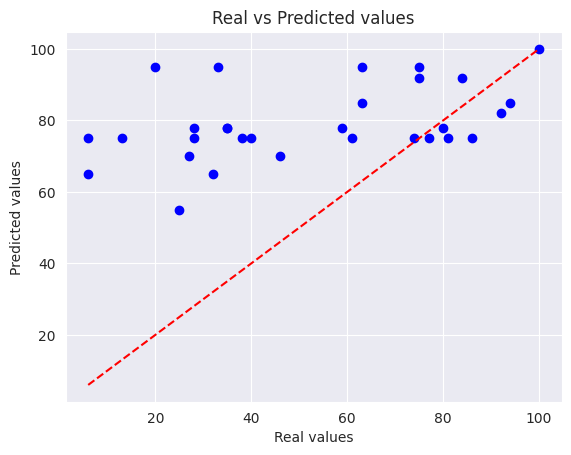

In [68]:
show_scatter_plot(yval_score, flash_assessment_list[0])

### Gemini 2.0 Flash-Lite

In [10]:
lite_assessment_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_2_flash_lite_structured,
                                              {
                                                  "blog_ex1" : best_blog["blog"],
                                                  "score_ex1" : best_blog["score"],
                                                  "blog_ex2" : worst_blog["blog"],
                                                  "score_ex2" : worst_blog["score"]
                                              })
    if ERROR_VALUE in lite_assessment:
        continue
    successful_attempts += 1
    lite_assessment_list.append(lite_assessment)

In [16]:
print_and_save_numeric_results(NUMERIC_RESULTS_PATH, yval_score, lite_assessment_list, "Gemini 2.0 Flash-Lite", 5)

Root Mean Square Error on validation set after 5 same experiments: [34.0, 33.0, 33.9, 34.9, 34.8]
Mean Absolute Error on validation set after 5 same experiments: [27.7, 25.5, 27.2, 28.6, 27.5]


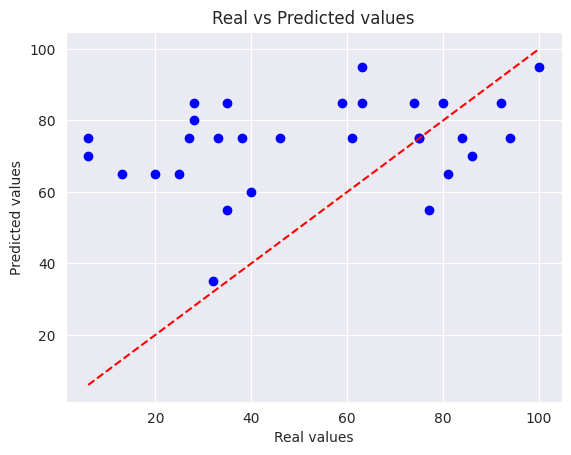

In [19]:
show_scatter_plot(yval_score, lite_assessment_list[0])

### Gemini 1.5 Flash

In [ ]:
flash1_assessment_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_assessment = extract_llm_assessment(Xval, prompt_two_shots, gemini_1_5_flash_structured,
                                              {
                                                  "blog_ex1" : best_blog["blog"],
                                                  "score_ex1" : best_blog["score"],
                                                  "blog_ex2" : worst_blog["blog"],
                                                  "score_ex2" : worst_blog["score"]
                                              })
    if ERROR_VALUE in flash1_assessment:
        continue
    successful_attempts += 1
    flash1_assessment_list.append(flash1_assessment)

In [18]:
print_and_save_numeric_results(NUMERIC_RESULTS_PATH, yval_score, flash1_assessment_list, "Gemini 1.5 Flash", 10)

Root Mean Square Error on validation set after 5 same experiments: [37.0, 36.6, 37.7, 36.1, 35.9]
Mean Absolute Error on validation set after 5 same experiments: [30.5, 30.3, 30.9, 29.0, 29.3]


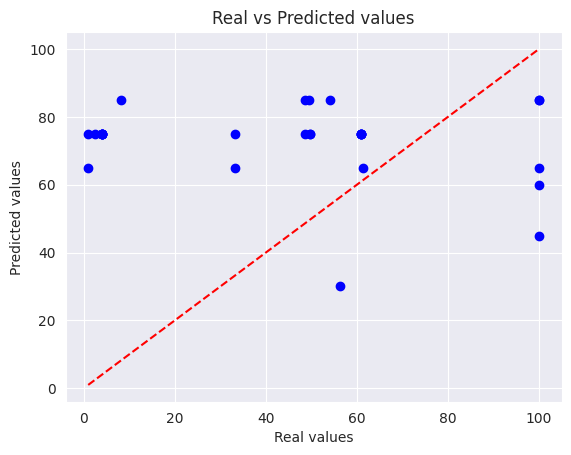

In [30]:
show_scatter_plot(yval_score, flash1_assessment_list[0])

## Normalized numeric evaluation with two-shot prompt

### Gemini 2.0 Flash

In [69]:
flash_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
flash_assessment_scaler.fit(np.array(flash_assessment_list).flatten().reshape(-1, 1))
scaled_flash_assessment_list = []
for assessment in flash_assessment_list:
    scaled_assessment = flash_assessment_scaler.transform(np.array(assessment).reshape(-1, 1))
    scaled_flash_assessment_list.append(scaled_assessment)

print_and_save_numeric_results(NORMALIZED_NUMERIC_RESULTS_PATH, yval_score, scaled_flash_assessment_list, "Gemini 2.0 Flash", 0)

Root Mean Square Error on validation set after 5 same experiments: [29.7, 27.4, 25.3, 25.7, 28.6]
Mean Absolute Error on validation set after 5 same experiments: [24.0, 23.3, 21.7, 22.8, 24.3]


### Gemini 2.0 Flash-Lite

In [70]:
lite_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
lite_assessment_scaler.fit(np.array(lite_assessment_list).flatten().reshape(-1, 1))
scaled_lite_assessment_list = []
for assessment in lite_assessment_list:
    scaled_assessment = lite_assessment_scaler.transform(np.array(assessment).reshape(-1, 1))
    scaled_lite_assessment_list.append(scaled_assessment)

print_and_save_numeric_results(NORMALIZED_NUMERIC_RESULTS_PATH, yval_score, scaled_lite_assessment_list, "Gemini 2.0 Flash-Lite", 5)

Root Mean Square Error on validation set after 5 same experiments: [32.8, 31.2, 32.2, 34.0, 33.8]
Mean Absolute Error on validation set after 5 same experiments: [27.3, 24.2, 26.7, 28.7, 27.2]


### Gemini 1.5 Flash

In [71]:
flash1_assessment_scaler = MinMaxScaler(feature_range=(1, 100))
flash1_assessment_scaler.fit(np.array(flash1_assessment_list).flatten().reshape(-1, 1))
scaled_flash1_assessment_list = []
for assessment in flash1_assessment_list:
    scaled_assessment = flash1_assessment_scaler.transform(np.array(assessment).reshape(-1, 1))
    scaled_flash1_assessment_list.append(scaled_assessment)

print_and_save_numeric_results(NORMALIZED_NUMERIC_RESULTS_PATH, yval_score, scaled_flash1_assessment_list, "Gemini 1.5 Flash", 10)

Root Mean Square Error on validation set after 5 same experiments: [31.9, 31.0, 34.0, 31.9, 30.4]
Mean Absolute Error on validation set after 5 same experiments: [26.5, 25.0, 28.7, 25.8, 23.9]


## Classification with five-shot prompt

In [77]:
# Models
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassification, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassification, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassification, include_raw=True)

### Gemini 2.0 Flash

In [78]:
flash_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_structured,
                                                  examples=
                                                  {
                                                      "excellent_blog" : excellent_blog,
                                                      "very_good_blog" : very_good_blog,
                                                      "good_blog" : good_blog,
                                                      "average_blog" : average_blog,
                                                      "bad_blog" : bad_blog
                                                  })
    if ERROR_VALUE in flash_classification:
        continue
    successful_attempts += 1
    flash_classification_list.append(flash_classification)

In [90]:
print_and_save_classification_results("Five-shot prompt", yval_level, flash_classification_list, "Gemini 2.0 Flash", 0)

Accuracy score on validation set after 5 same experiments (in %): [40.0, 36.7, 36.7, 36.7, 36.7]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.2, 1.4, 1.4, 1.5, 1.5]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [0.9, 1.0, 1.1, 1.1, 1.1]


### Gemini 2.0 Flash-Lite

In [ ]:
lite_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_2_flash_lite_structured,
                                                 examples=
                                                 {
                                                     "excellent_blog" : excellent_blog,
                                                     "very_good_blog" : very_good_blog,
                                                     "good_blog" : good_blog,
                                                     "average_blog" : average_blog,
                                                     "bad_blog" : bad_blog
                                                 })
    if ERROR_VALUE in lite_classification:
        continue
    successful_attempts += 1
    lite_classification_list.append(lite_classification)

In [92]:
print_and_save_classification_results("Five-shot prompt", yval_level, lite_classification_list, "Gemini 2.0 Flash-Lite", 5)

Accuracy score on validation set after 5 same experiments (in %): [33.3, 26.7, 30.0, 20.0, 30.0]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.3, 1.4, 1.5, 1.5, 1.5]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.0, 1.1, 1.2, 1.2, 1.2]


### Gemini 1.5 Flash

In [93]:
flash1_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_classification = extract_llm_assessment(Xval, prompt_five_shots, gemini_1_5_flash_structured,
                                                   examples=
                                                   {
                                                       "excellent_blog" : excellent_blog,
                                                       "very_good_blog" : very_good_blog,
                                                       "good_blog" : good_blog,
                                                       "average_blog" : average_blog,
                                                       "bad_blog" : bad_blog
                                                   })
    if ERROR_VALUE in flash1_classification:
        continue
    successful_attempts += 1
    flash1_classification_list.append(flash1_classification)

In [94]:
print_and_save_classification_results("Five-shot prompt", yval_level, flash1_classification_list, "Gemini 1.5 Flash", 10)

Accuracy score on validation set after 5 same experiments (in %): [36.7, 36.7, 36.7, 33.3, 36.7]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.4, 1.4, 1.3, 1.4, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.0, 1.0, 1.0, 1.1, 1.0]


## Classification with Chain-of-Thoughts prompt

In [95]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationCoT, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationCoT, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationCoT, include_raw=True)

### Gemini 2.0 Flash

In [96]:
flash_cot_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in flash_cot_classification:
        continue
    successful_attempts += 1
    flash_cot_classification_list.append(flash_cot_classification)

In [97]:
print_and_save_classification_results("Zero-shot CoT prompt", yval_level, flash_cot_classification_list, "Gemini 2.0 Flash", 0)

Accuracy score on validation set after 5 same experiments (in %): [26.7, 26.7, 36.7, 23.3, 26.7]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.2, 1.4, 1.2, 1.2, 1.2]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.0, 1.1, 0.9, 1.0, 1.0]


### Gemini 2.0 Flash-Lite

In [ ]:
lite_cot_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_2_flash_lite_structured, examples={})

    if ERROR_VALUE in lite_cot_classification:
        continue
    successful_attempts += 1
    lite_cot_classification_list.append(lite_cot_classification)

In [99]:
print_and_save_classification_results("Zero-shot CoT prompt", yval_level, lite_cot_classification_list, "Gemini 2.0 Flash-Lite", 5)

Accuracy score on validation set after 5 same experiments (in %): [20.0, 20.0, 40.0, 16.7, 20.0]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.4, 1.5, 1.4, 1.6, 1.5]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.2, 1.2, 1.0, 1.3, 1.2]


### Gemini 1.5 Flash

In [100]:
flash1_cot_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_cot_classification = extract_llm_assessment(Xval, prompt_zero_cot, gemini_1_5_flash_structured, examples={})

    if ERROR_VALUE in flash1_cot_classification:
        continue
    successful_attempts += 1
    flash1_cot_classification_list.append(flash1_cot_classification)

In [101]:
print_and_save_classification_results("Zero-shot CoT prompt", yval_level, flash1_cot_classification_list, "Gemini 1.5 Flash", 10)

Accuracy score on validation set after 5 same experiments (in %): [16.7, 26.7, 13.3, 26.7, 30.0]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.8, 1.9, 1.8, 1.7, 1.9]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.5, 1.5, 1.5, 1.3, 1.4]


## Classification with generated knowledge prompt

In [155]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationGK, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationGK, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationGK, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_gk_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in flash_gk_classification:
        continue
    successful_attempts += 1
    flash_gk_classification_list.append(flash_gk_classification)

In [157]:
print_and_save_classification_results("Generated Knowledge prompt", yval_level, flash_gk_classification_list, "Gemini 2.0 Flash", 0)

Accuracy score on validation set after 5 same experiments (in %): [36.7, 46.7, 43.3, 33.3, 30.0]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.2, 1.2, 1.3, 1.3, 1.3]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [0.9, 0.8, 0.9, 1.0, 1.0]


### Gemini 2.0 Flash-Lite

In [ ]:
lite_gk_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_2_flash_lite_structured, examples={})

    if ERROR_VALUE in lite_gk_classification:
        continue
    successful_attempts += 1
    lite_gk_classification_list.append(lite_gk_classification)

In [159]:
print_and_save_classification_results("Generated Knowledge prompt", yval_level, lite_gk_classification_list, "Gemini 2.0 Flash-Lite", 5)

Accuracy score on validation set after 5 same experiments (in %): [20.0, 20.0, 20.0, 23.3, 20.0]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.4, 1.5, 1.6, 1.6, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.1, 1.2, 1.3, 1.3, 1.2]


### Gemini 1.5 Flash

In [ ]:
flash1_gk_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_gk_classification = extract_llm_assessment(Xval, prompt_generated_knowledge, gemini_1_5_flash_structured, examples={})

    if ERROR_VALUE in flash1_gk_classification:
        continue
    successful_attempts += 1
    flash1_gk_classification_list.append(flash1_gk_classification)

In [161]:
print_and_save_classification_results("Generated Knowledge prompt", yval_level, flash1_gk_classification_list, "Gemini 1.5 Flash", 10)

Accuracy score on validation set after 5 same experiments (in %): [30.0, 30.0, 23.3, 33.3, 30.0]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.3, 1.4, 1.4, 1.4, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.0, 1.1, 1.2, 1.1, 1.1]


## Classification with Meta prompt

In [162]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationMP, include_raw=True)
gemini_2_flash_lite_structured = gemini_2_flash_lite.with_structured_output(BlogClassificationMP, include_raw=True)
gemini_1_5_flash_structured = gemini_1_5_flash.with_structured_output(BlogClassificationMP, include_raw=True)

### Gemini 2.0 Flash

In [ ]:
flash_mp_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in flash_mp_classification:
        continue
    successful_attempts += 1
    flash_mp_classification_list.append(flash_mp_classification)

In [164]:
print_and_save_classification_results("Meta prompt", yval_level, flash_mp_classification_list, "Gemini 2.0 Flash", 0)

Accuracy score on validation set after 5 same experiments (in %): [20.0, 40.0, 33.3, 36.7, 26.7]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.4, 1.2, 1.3, 1.3, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.2, 0.9, 1.0, 1.0, 1.1]


### Gemini 2.0 Flash-Lite

In [ ]:
lite_mp_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    lite_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_2_flash_lite_structured, examples={})

    if ERROR_VALUE in lite_mp_classification:
        continue
    successful_attempts += 1
    lite_mp_classification_list.append(lite_mp_classification)

In [166]:
print_and_save_classification_results("Meta prompt", yval_level, lite_mp_classification_list, "Gemini 2.0 Flash-Lite", 5)

Accuracy score on validation set after 5 same experiments (in %): [26.7, 16.7, 30.0, 20.0, 30.0]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.5, 1.5, 1.3, 1.4, 1.4]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.2, 1.3, 1.0, 1.2, 1.1]


### Gemini 1.5 Flash

In [167]:
flash1_mp_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    flash1_mp_classification = extract_llm_assessment(Xval, prompt_meta, gemini_1_5_flash_structured, examples={})

    if ERROR_VALUE in flash1_mp_classification:
        continue
    successful_attempts += 1
    flash1_mp_classification_list.append(flash1_mp_classification)

In [168]:
print_and_save_classification_results("Meta prompt", yval_level, flash1_mp_classification_list, "Gemini 1.5 Flash", 10)

Accuracy score on validation set after 5 same experiments (in %): [16.7, 10.0, 23.3, 26.7, 20.0]
Root Mean Square Error on validation set after using the verbal classification after 5 same experiments: [1.5, 1.6, 1.6, 1.7, 1.5]
Mean Absolute Error on validation set after using verbal after 5 same experiments: [1.2, 1.4, 1.2, 1.2, 1.3]


# Results

In [352]:
def show_metric_bar_plot(models, values, metric, error):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 6))
    plt.bar(models, values, color='orange', yerr=error, capsize=5, edgecolor='black')
    plt.title(f'{metric} comparison for different models')
    plt.ylabel(f'{metric}')
    plt.ylim(min(values) - 2, max(values) + 2)
    plt.tight_layout()
    plt.show()

def show_metric_heat_map(data, metric, reverse_color=True):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data.set_index('Model'), annot=True, cmap='coolwarm_r' if reverse_color else 'coolwarm', fmt='.2f')
    plt.title(f'Heatmap of {metric}')
    plt.yticks(rotation=0)
    plt.xticks(rotation=45)
    plt.show()

## Numeric evaluation with two-shot prompt

In [353]:
num_eval_results = pd.read_csv(NUMERIC_RESULTS_PATH)
average_num_eval_results = num_eval_results.groupby("Model").agg({
    'RMSE': 'mean',
    'MAE': 'mean'
}).reset_index().round(2)
print(f"Average error values")
average_num_eval_results

Average error values


,Model,RMSE,MAE
0,Gemini 1.5 Flash,36.66,30.00
1,Gemini 2.0 Flash,34.32,28.08
2,Gemini 2.0 Flash-Lite,34.12,27.30


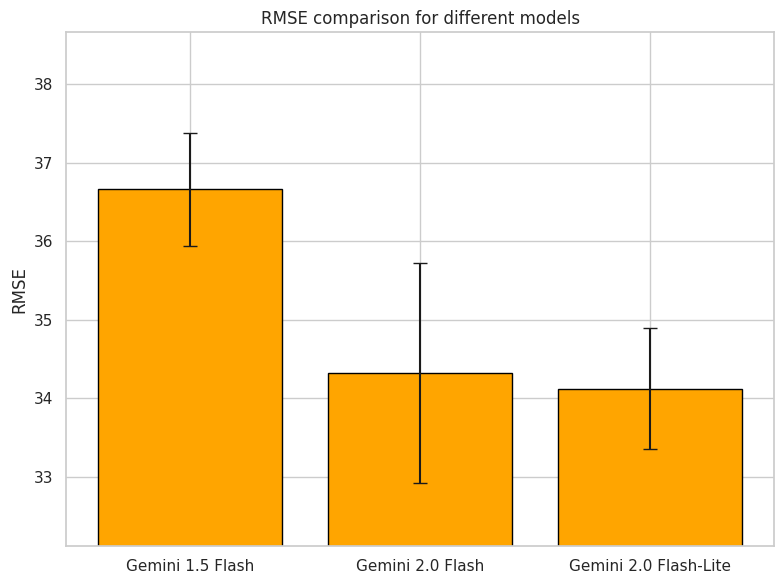

In [354]:
RMSE_std = num_eval_results.groupby("Model")["RMSE"].std().reset_index().round(2)["RMSE"].tolist()
show_metric_bar_plot(average_num_eval_results["Model"], average_num_eval_results["RMSE"], "RMSE", RMSE_std)

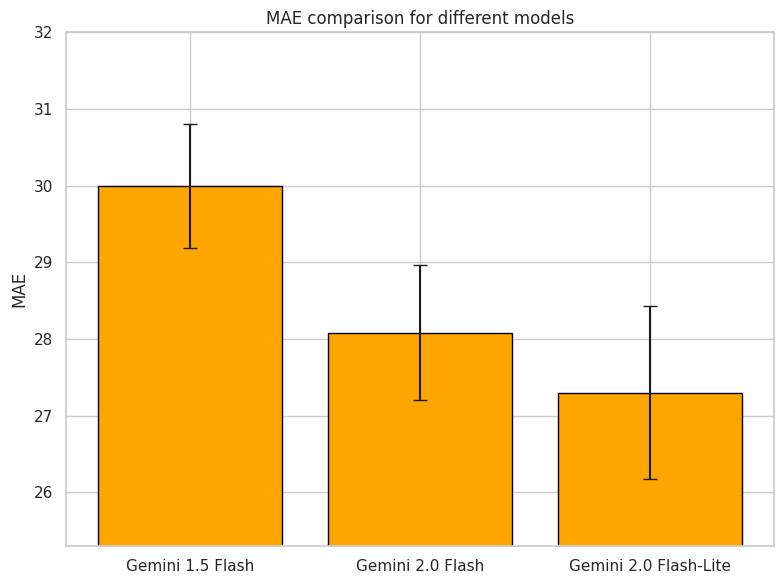

In [355]:
MAE_std = num_eval_results.groupby("Model")["MAE"].std().reset_index().round(2)["MAE"].tolist()
show_metric_bar_plot(average_num_eval_results["Model"], average_num_eval_results["MAE"], "MAE", MAE_std)

## Normalized numeric evaluation with two-shot prompt

In [356]:
norm_num_eval_results = pd.read_csv(NORMALIZED_NUMERIC_RESULTS_PATH)
average_norm_num_eval_results = norm_num_eval_results.groupby("Model").agg({
    'RMSE': 'mean',
    'MAE': 'mean'
}).reset_index().round(2)
print(f"Average error values")
average_norm_num_eval_results

Average error values


,Model,RMSE,MAE
0,Gemini 1.5 Flash,31.84,25.98
1,Gemini 2.0 Flash,27.34,23.22
2,Gemini 2.0 Flash-Lite,32.80,26.82


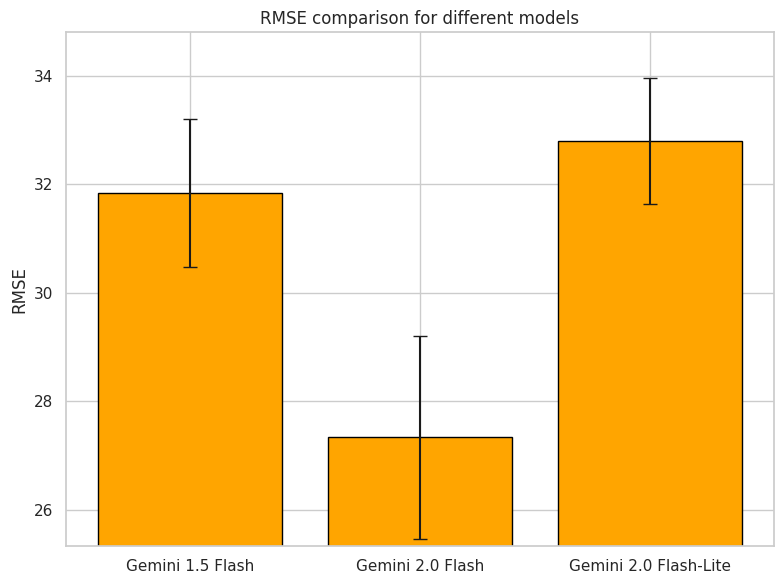

In [357]:
RMSE_std = norm_num_eval_results.groupby("Model")["RMSE"].std().reset_index().round(2)["RMSE"].tolist()
show_metric_bar_plot(average_norm_num_eval_results["Model"], average_norm_num_eval_results["RMSE"], "RMSE", RMSE_std)

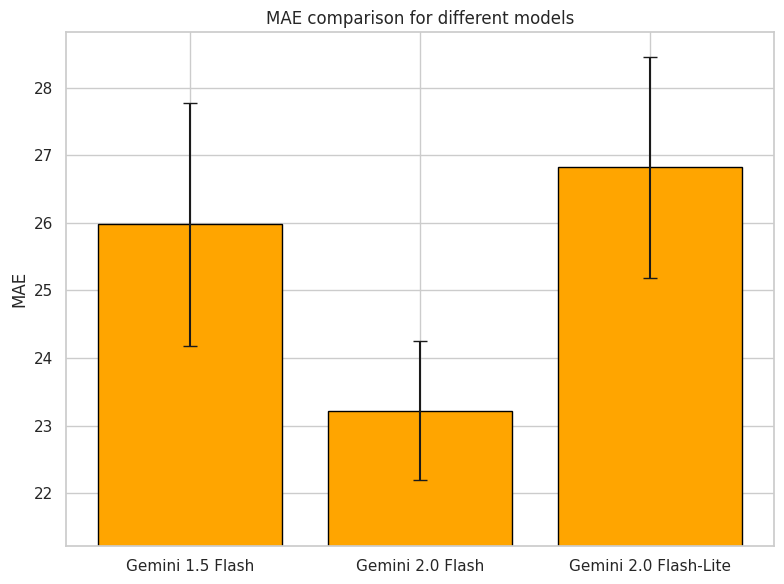

In [358]:
MAE_std = norm_num_eval_results.groupby("Model")["MAE"].std().reset_index().round(2)["MAE"].tolist()
show_metric_bar_plot(average_norm_num_eval_results["Model"], average_norm_num_eval_results["MAE"], "MAE", MAE_std)

## Classification RMSE

In [359]:
def show_metric_bar_plot_low(model, prompt_names, values, metric, error):
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 8))
    plt.bar(prompt_names, values, color='orange', yerr=error, capsize=5, edgecolor='black')
    plt.title(f'{model} {metric} comparison for different prompts')
    plt.ylabel(f'{metric}')
    plt.ylim(min(values) - (0.2 if metric != "Accuracy" else 10), max(values) + (0.2 if metric != "Accuracy" else 10))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

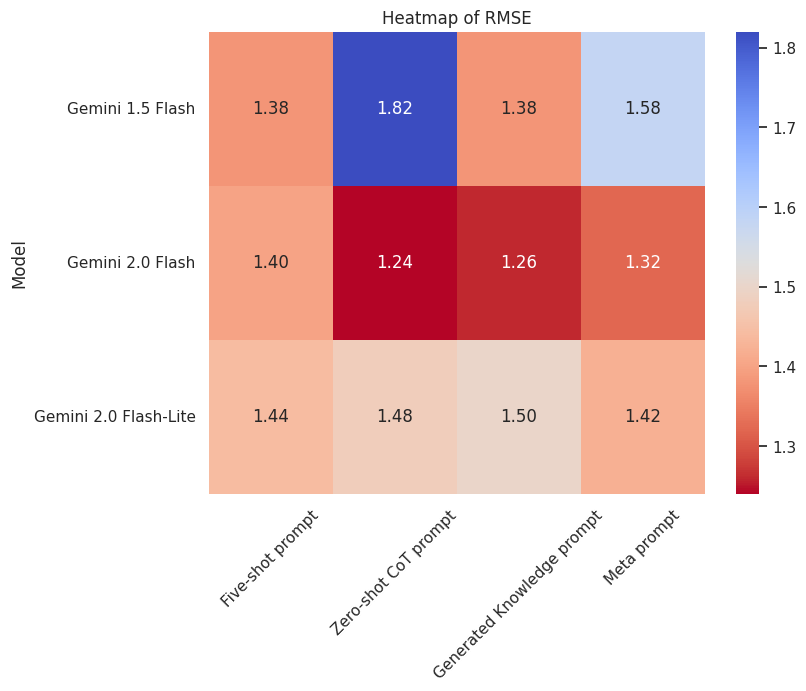

In [360]:
clas_RMSE = pd.read_csv(CLASSIFICATION_RMSE_RESULTS_PATH)
average_clas_RMSE = clas_RMSE.groupby("Model").agg({
    "Five-shot prompt": "mean",
    "Zero-shot CoT prompt": "mean",
    "Generated Knowledge prompt": "mean",
    "Meta prompt": "mean"
}).reset_index().round(2)
#print(f"Average RMSE values")
#average_clas_RMSE
show_metric_heat_map(average_clas_RMSE, "RMSE")

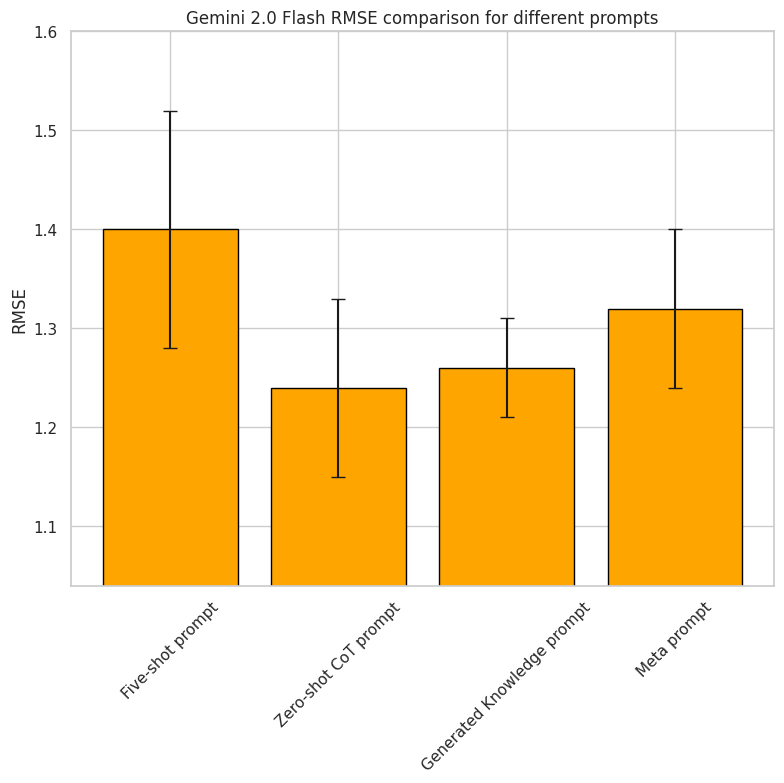

In [361]:
RMSE_std = clas_RMSE.groupby("Model").agg({
    "Five-shot prompt": "std",
    "Zero-shot CoT prompt": "std",
    "Generated Knowledge prompt": "std",
    "Meta prompt": "std"}).reset_index().round(2)
prompts = ["Five-shot prompt", "Zero-shot CoT prompt", "Generated Knowledge prompt", "Meta prompt"]
RMSE_std = RMSE_std[RMSE_std["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
average_values = average_clas_RMSE[average_clas_RMSE["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
show_metric_bar_plot_low("Gemini 2.0 Flash", prompts, average_values, "RMSE", RMSE_std)

## Classification MAE

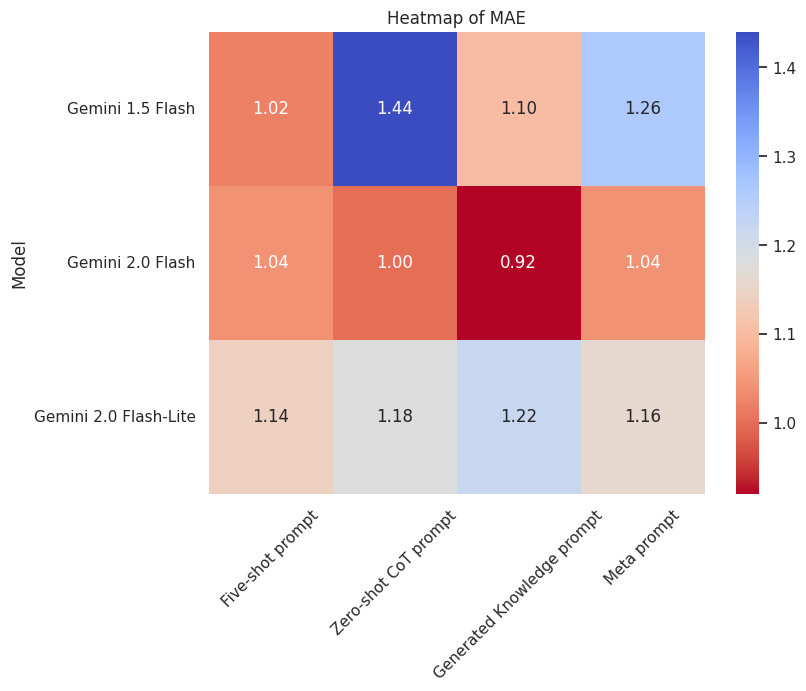

In [362]:
clas_MAE = pd.read_csv(CLASSIFICATION_MAE_RESULTS_PATH)
average_clas_MAE = clas_MAE.groupby("Model").agg({
    "Five-shot prompt": "mean",
    "Zero-shot CoT prompt": "mean",
    "Generated Knowledge prompt": "mean",
    "Meta prompt": "mean"
}).reset_index().round(2)
#print(f"Average MAE values")
#average_clas_MAE
show_metric_heat_map(average_clas_MAE, "MAE")

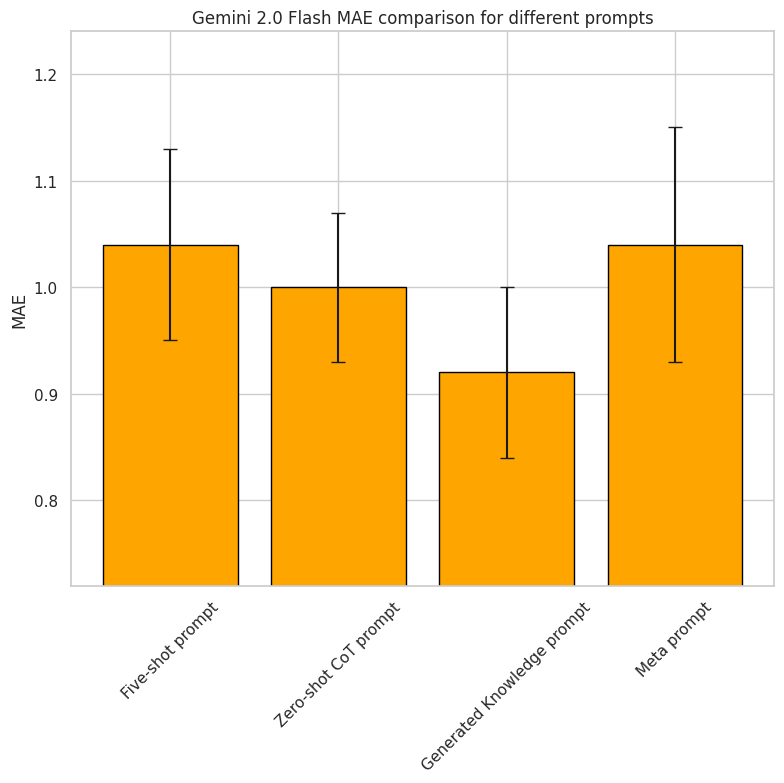

In [363]:
MAE_std = clas_MAE.groupby("Model").agg({
    "Five-shot prompt": "std",
    "Zero-shot CoT prompt": "std",
    "Generated Knowledge prompt": "std",
    "Meta prompt": "std"}).reset_index().round(2)
prompts = ["Five-shot prompt", "Zero-shot CoT prompt", "Generated Knowledge prompt", "Meta prompt"]
MAE_std = MAE_std[MAE_std["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
average_values = average_clas_MAE[average_clas_MAE["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
show_metric_bar_plot_low("Gemini 2.0 Flash", prompts, average_values, "MAE", MAE_std)

## Classification accuracy

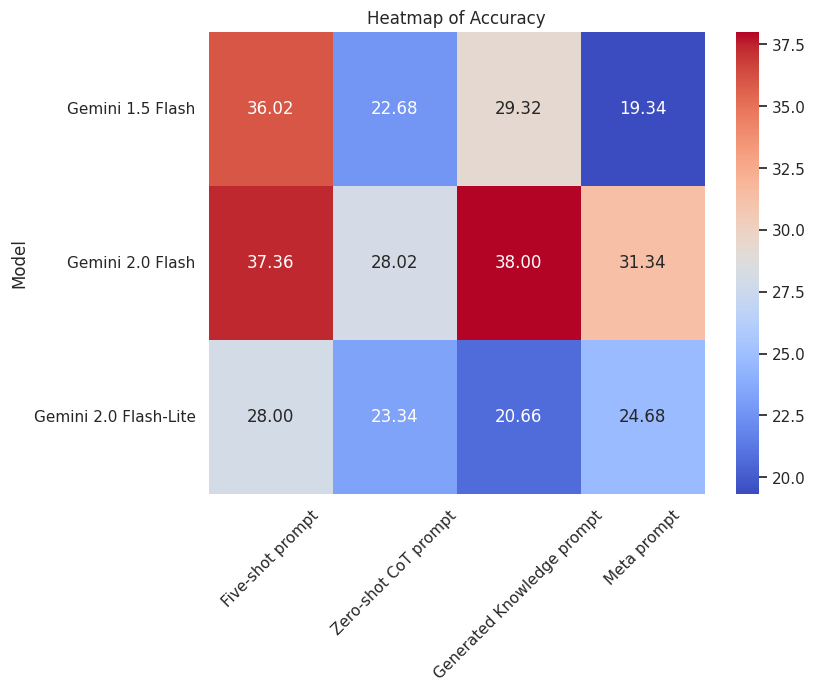

In [364]:
clas_ACC = pd.read_csv(CLASSIFICATION_ACC_RESULTS_PATH)
average_clas_ACC = clas_ACC.groupby("Model").agg({
    "Five-shot prompt": "mean",
    "Zero-shot CoT prompt": "mean",
    "Generated Knowledge prompt": "mean",
    "Meta prompt": "mean"
}).reset_index().round(2)
#print(f"Average Accuracy values")
#average_clas_ACC
show_metric_heat_map(average_clas_ACC, "Accuracy", reverse_color=False)

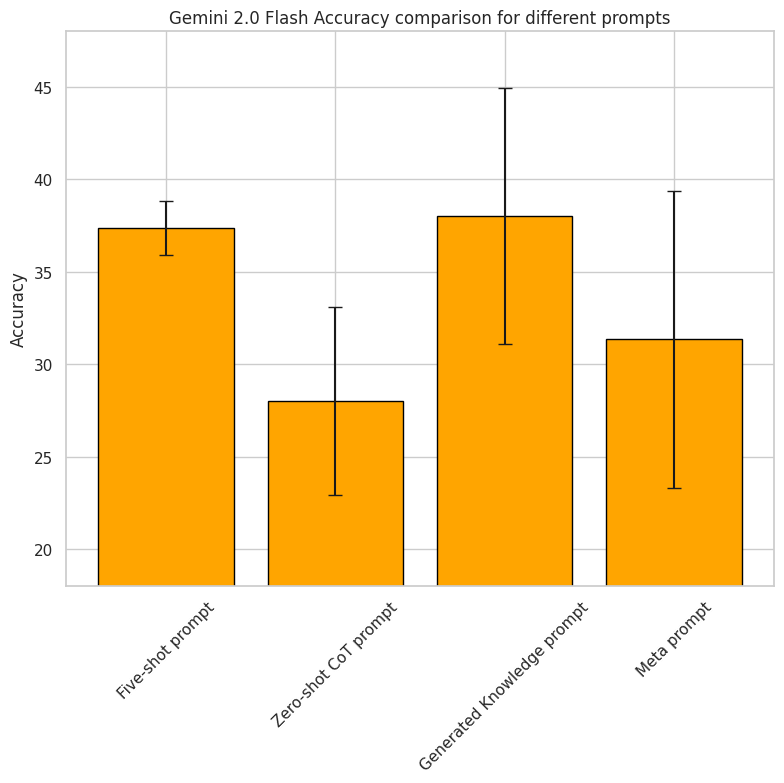

In [365]:
ACC_std = clas_ACC.groupby("Model").agg({
    "Five-shot prompt": "std",
    "Zero-shot CoT prompt": "std",
    "Generated Knowledge prompt": "std",
    "Meta prompt": "std"}).reset_index().round(2)
prompts = ["Five-shot prompt", "Zero-shot CoT prompt", "Generated Knowledge prompt", "Meta prompt"]
ACC_std = ACC_std[ACC_std["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
average_values = average_clas_ACC[average_clas_ACC["Model"] == "Gemini 2.0 Flash"].reset_index().loc[0][prompts].tolist()
show_metric_bar_plot_low("Gemini 2.0 Flash", prompts, average_values, "Accuracy", ACC_std)

# Additional experiment on Google DeepMind blogs

## Zero-shot Chain-of-Thoughts prompt

In [32]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationCoT, include_raw=True)

In [33]:
google_cot_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    google_cot_classification = extract_llm_assessment(google_blogs, prompt_zero_cot, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in google_cot_classification:
        continue
    successful_attempts += 1
    google_cot_classification_list.append(google_cot_classification)

## Generated Knowledge prompt

In [34]:
gemini_2_flash_structured = gemini_2_flash.with_structured_output(BlogClassificationGK, include_raw=True)

In [ ]:
google_gk_classification_list = []
successful_attempts = 0
while successful_attempts < REPETITION:
    google_gk_classification = extract_llm_assessment(google_blogs, prompt_generated_knowledge, gemini_2_flash_structured, examples={})

    if ERROR_VALUE in google_gk_classification:
        continue
    successful_attempts += 1
    google_gk_classification_list.append(google_gk_classification)

## Save Results

In [ ]:
for classification in google_cot_classification_list:
    for i in range(len(classification)):
        classification[i] = CLASSIFICATION_MAP[classification[i]]

for classification in google_gk_classification_list:
    for i in range(len(classification)):
        classification[i] = CLASSIFICATION_MAP[classification[i]]

In [ ]:
google_cot_classification_list = np.array(google_cot_classification_list)
google_gk_classification_list = np.array(google_gk_classification_list)

google_cot_classification_list = np.mean(google_cot_classification_list, axis=0)
google_gk_classification_list = np.mean(google_gk_classification_list, axis=0)

In [49]:
blog_eval = {
    "Zero-shot CoT prompt": google_cot_classification_list,
    "Generated Knowledge prompt": google_gk_classification_list
}
google_blog_evaluation = pd.DataFrame(blog_eval)
google_blog_evaluation.to_csv(DEEPMIND_BLOG_EVALUATION_RESULTS_PATH, index=False)

## Results

In [2]:
google_blog_evaluation = pd.read_csv(DEEPMIND_BLOG_EVALUATION_RESULTS_PATH)

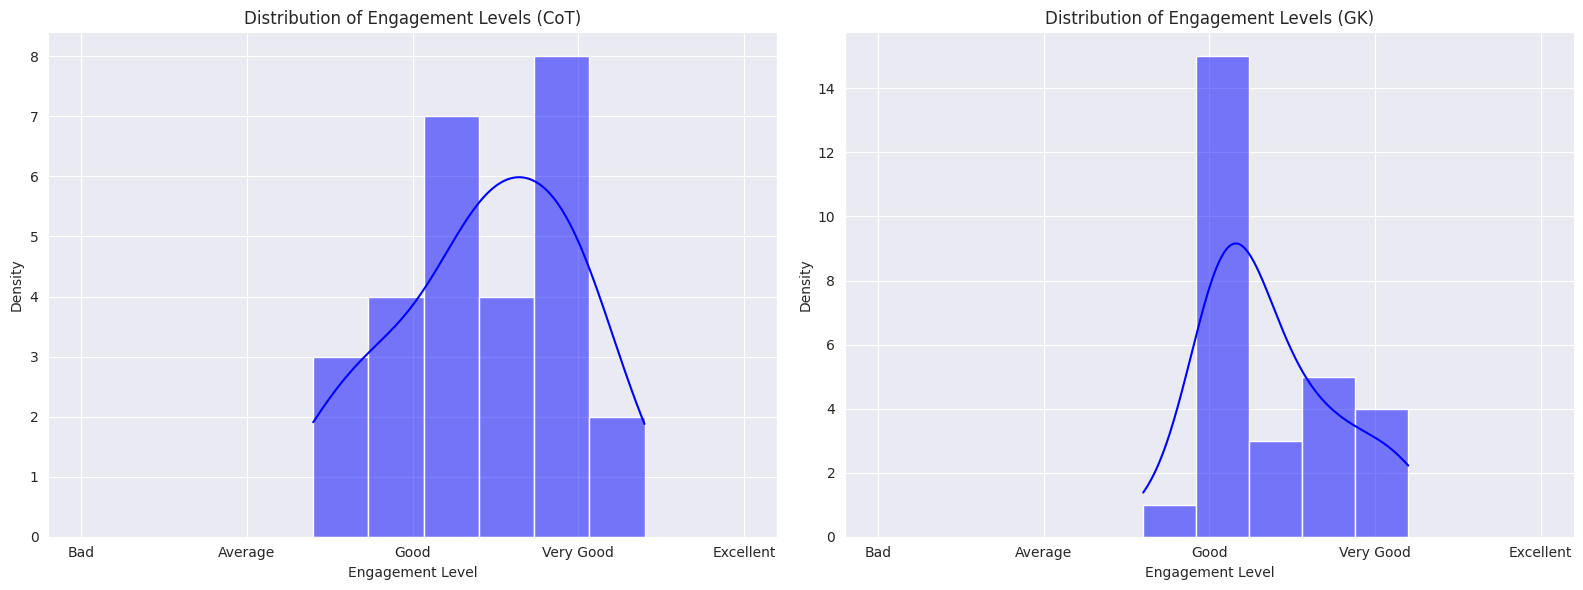

In [3]:
padding = 0.2

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(google_blog_evaluation["Zero-shot CoT prompt"].tolist(), bins=6, kde=True, color="blue", ax=axes[0])
axes[0].set_xticks(ticks=range(1, 6), labels=["Bad", "Average", "Good", "Very Good", "Excellent"])
axes[0].set_xlim(1 - padding, 5 + padding)
axes[0].set_xlabel("Engagement Level")
axes[0].set_ylabel("Density")
axes[0].set_title("Distribution of Engagement Levels (CoT)")

sns.histplot(google_blog_evaluation["Generated Knowledge prompt"].tolist(), bins=5, kde=True, color="blue", ax=axes[1])
axes[1].set_xticks(ticks=range(1, 6), labels=["Bad", "Average", "Good", "Very Good", "Excellent"])
axes[1].set_xlim(1 - padding, 5 + padding)
axes[1].set_xlabel("Engagement Level")
axes[1].set_ylabel("Density")
axes[1].set_title("Distribution of Engagement Levels (GK)")

plt.tight_layout()
plt.show()